# Notebook: comparison tests
    by Ulrich Voggenberger
    16.11.2021


In [1]:
# System information
import numpy as np
import matplotlib.pyplot as plt
import os, sys, glob, time, shutil
import pandas as pd
import xarray as xr
import h5py
import pickle
import netCDF4 as nc
import multiprocessing
from functools import partial
import datetime
from scipy import stats
import cdsapi
import zipfile
import warnings
warnings.filterwarnings('ignore')

In [2]:
# not a downloadable python module, just used for plotting
sys.path.append(os.getcwd()+'/../resort/rasotools-master/')
import rasotools


In [3]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
plt.rcParams['figure.figsize'] = [12, 8]


In [4]:
def seconds_to_datetime(seconds, ref='1900-01-01'):
    """ from seconds to datetime64 """
    seconds = np.asarray(seconds)
    return pd.to_datetime(seconds, unit='s', origin=ref).values

In [5]:
def calc_anomaly(data, date, mean_preset = None):
    data_c = data.copy()
    if mean_preset == None:
        mean = [0]*12
        count = [0]*12
        for i in range(len(data_c)):
            if not np.isnan(data_c[i]):
                for j in range(1, 13):
                    if date[i].month == j:
                        mean[j-1] += data_c[i]
                        count[j-1] += 1
                        break
        for j in range(1,13):
            try:
                mean[j-1] = mean[j-1]/count[j-1]
            except:
                mean[j-1] = np.nan
    else:
        mean = mean_preset
    for i in range(len(data_c)):
        if not np.isnan(data_c[i]):
            for j in range(1,13):
                if date[i].month == j:
                    data_c[i] -= mean[j-1]
    return data_c, mean

In [6]:
def request(r_dict, dataset, data_dir = './comparison_dir', rm_files = False):
    try:
        os.makedirs(data_dir)
    except:
        pass

    tt = time.time()
    c = cdsapi.Client()
    r = c.retrieve(dataset,r_dict)
    tr = time.time()
    r.download(target='download.zip')
    tdl = time.time()
    z = zipfile.ZipFile('download.zip')
    z.extractall(path = data_dir+'/')
    z.close()
    tuz = time.time()

    print('request: ', tr - tt, ' s')
    print('download: ', tdl - tr, ' s')
    print('over all : ', tdl - tt, ' s \n-')
    print('unzip: ', tuz - tdl, ' s \n-')
    
    print('zip size: ', os.path.getsize('download.zip')/1000000., ' MB')
    filesize_token = 0
    for filename in os.listdir(data_dir):
        file_path = os.path.join(data_dir, filename)
        filesize_token += os.path.getsize('download.zip')
        if rm_files:
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print('Failed to delete %s. Reason: %s' % (file_path, e))
    print('file size: ', filesize_token/1000000., ' MB')


## 1) calculation of the cold tropopause point for each station

In [7]:
def ctp(stat):
    file_path = './comparison_dir/0'
    request({'variable': ["temperature"],
             'date': ['19780101','20201231'],
             'statid': stat,
             'format': 'csv',
             'cached': 0,
            }, 
            'insitu-comprehensive-upper-air-observation-network',
            data_dir = file_path,
            rm_files = False)
    file = glob.glob(file_path+'/*.csv.gz')[0]
    data = pd.read_csv(file, compression='gzip')
    data.date_time = seconds_to_datetime(data.date_time)

    # only calc cold trop. point for June
    selected_data = data[data.date_time.dt.month == 6]

    height = []
    counter = 0
    for i in np.unique(selected_data.date_time):
        temp_data = selected_data[selected_data.date_time == i]
        temp_data = temp_data[temp_data.observation_value == (temp_data.observation_value.min())].z_coordinate
        try:
            if ~ np.isnan(temp_data.iloc[0]):
                height.append(temp_data.iloc[0])
                counter += 1
        except:
            pass
    # delete downloaded files
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))
    return np.nansum(height)/ counter, data.latitude.iloc[0], data.longitude.iloc[0]

In [10]:
ctps = []
lats = []
lons = []
for i in ['11035', '72357', '50527']:
    c, la, lo = ctp(i)
    ctps.append(c)
    lats.append(la)
    lons.append(lo)

2021-11-19 15:05:10,960 INFO Welcome to the CDS
2021-11-19 15:05:10,961 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-11-19 15:05:11,490 INFO Request is completed
2021-11-19 15:05:11,491 INFO Downloading http://download-0001-sisdev.copernicus-climate.eu/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1637323711.1811874-12323-1-62a29866-a3a0-4807-8308-f5e1640f814f.zip to download.zip (33.2M)
2021-11-19 15:05:12,345 INFO Download rate 38.9M/s                              


request:  0.6712448596954346  s
download:  0.8545577526092529  s
over all :  1.5258026123046875  s 
-
unzip:  0.18259787559509277  s 
-
zip size:  34.85825  MB
file size:  34.85825  MB


2021-11-19 15:05:23,710 INFO Welcome to the CDS
2021-11-19 15:05:23,711 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-11-19 15:05:23,784 INFO Request is completed
2021-11-19 15:05:23,785 INFO Downloading http://download-0001-sisdev.copernicus-climate.eu/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1637330632.2505145-12339-1-9662f0d1-f440-44ea-adc9-0fded94e06c6.zip to download.zip (13.3M)
2021-11-19 15:05:24,324 INFO Download rate 24.7M/s                              


request:  0.10656547546386719  s
download:  0.5396738052368164  s
over all :  0.6462392807006836  s 
-
unzip:  0.12074494361877441  s 
-
zip size:  13.971713  MB
file size:  13.971713  MB


2021-11-19 15:05:29,728 INFO Welcome to the CDS
2021-11-19 15:05:29,730 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-11-19 15:05:29,782 INFO Request is queued
2021-11-19 15:05:30,818 INFO Request is running
2021-11-19 15:05:34,640 INFO Request is completed
2021-11-19 15:05:34,641 INFO Downloading http://download-0001-sisdev.copernicus-climate.eu/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1637330734.260556-12362-1-e417e2de-c584-4507-b6f4-f94de73df1c4.zip to download.zip (4.9M)
2021-11-19 15:05:34,990 INFO Download rate 14M/s                                


request:  4.9434120655059814  s
download:  0.3493845462799072  s
over all :  5.292796611785889  s 
-
unzip:  0.045589447021484375  s 
-
zip size:  5.119814  MB
file size:  5.119814  MB


In [17]:
# add just empty values
ctps.append(np.nan)
lats.append(-90)
lons.append(-180)

ctps.append(np.nan)
lats.append(90)
lons.append(180)

<GeoAxesSubplot:title={'center':' (# 3 / 7)'}>

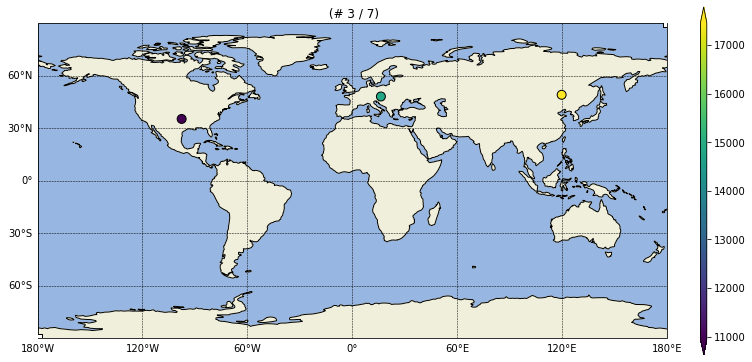

In [18]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
plt.rcParams['figure.figsize'] = [12, 8]

rasotools.plot.map.points(lon=np.array(lons), lat=np.array(lats), values=np.array(ctps),)

 ## 2) calculation of monthly temperature anomalies (from 1978 to 2020, at all mandatory pressure levels from 850 to 10 hPa)

### CDS request

In [19]:
request({'variable': ["temperature"],
         'date': ['19780101','20201231'],
         'statid': '11035',
         'cached': 0,
        }, 
        'insitu-comprehensive-upper-air-observation-network',
        data_dir = './comparison_dir/1',
        rm_files = True)

2021-11-19 15:08:35,001 INFO Welcome to the CDS
2021-11-19 15:08:35,002 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-11-19 15:08:35,589 INFO Request is completed
2021-11-19 15:08:35,590 INFO Downloading http://download-0001-sisdev.copernicus-climate.eu/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1637323667.9947464-12319-1-dde2ce8d-e57c-421f-ae65-ee32250a96b2.zip to download.zip (59.5M)
2021-11-19 15:08:37,340 INFO Download rate 34M/s                                


request:  0.7130279541015625  s
download:  1.7504470348358154  s
over all :  2.463474988937378  s 
-
unzip:  0.30443453788757324  s 
-
zip size:  62.341331  MB
file size:  124.682662  MB


In [20]:
request({'variable': ["temperature"],
         'date': ['19780101','20201231'],
         'statid': '11035',
         'format': 'csv',
         'cached': 0,
        }, 
        'insitu-comprehensive-upper-air-observation-network',
        data_dir = './comparison_dir/1',
        rm_files = True)

2021-11-19 15:08:37,746 INFO Welcome to the CDS
2021-11-19 15:08:37,747 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-11-19 15:08:37,806 INFO Request is completed
2021-11-19 15:08:37,806 INFO Downloading http://download-0001-sisdev.copernicus-climate.eu/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1637323711.1811874-12323-1-62a29866-a3a0-4807-8308-f5e1640f814f.zip to download.zip (33.2M)
2021-11-19 15:08:38,639 INFO Download rate 39.9M/s                              


request:  0.0906214714050293  s
download:  0.8333430290222168  s
over all :  0.9239645004272461  s 
-
unzip:  0.13383984565734863  s 
-
zip size:  34.85825  MB
file size:  34.85825  MB


In [21]:
request({'variable': ["temperature"],
         'date': ['19780101','20201231'],
         'statid': '11035',
         'format': 'fast_csv',
         'cached': 0,
        }, 
        'insitu-comprehensive-upper-air-observation-network',
        data_dir = './comparison_dir/1',
        rm_files = False)

2021-11-19 15:08:38,859 INFO Welcome to the CDS
2021-11-19 15:08:38,860 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-11-19 15:08:38,920 INFO Request is completed
2021-11-19 15:08:38,921 INFO Downloading http://download-0001-sisdev.copernicus-climate.eu/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1637323746.8317966-12327-1-f51446e0-03df-4618-9541-a5ce00c88996.zip to download.zip (29.5M)
2021-11-19 15:08:39,692 INFO Download rate 38.3M/s                              


request:  0.09181714057922363  s
download:  0.7713899612426758  s
over all :  0.8632071018218994  s 
-
unzip:  0.15118145942687988  s 
-
zip size:  30.906133  MB
file size:  30.906133  MB


---

In [22]:
request({'source': 'IGRA',
         'variable':['air_temperature'],
         'period':'1978-01-01/2020-12-31',
         'station_name':'AUM00011035',
         'format':'csv',
         'cached': 1,
        }, 
        'insitu-observations-igra-baseline-network',
        data_dir = './comparison_dir/1_i',
        rm_files = False)

2021-11-19 15:08:39,924 INFO Welcome to the CDS
2021-11-19 15:08:39,925 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-observations-igra-baseline-network
2021-11-19 15:08:39,975 INFO Request is completed
2021-11-19 15:08:39,975 INFO Downloading http://download-0001-sisdev.copernicus-climate.eu/cache-compute-0001/cache/data1/adaptor.insitu_reference.retrieve-1637155876.395047-23693-1-8ce0d4be-448c-461a-a45a-50145e69be5d.zip to download.zip (9.3M)
2021-11-19 15:08:40,533 INFO Download rate 16.6M/s                              


request:  0.08088040351867676  s
download:  0.5583698749542236  s
over all :  0.6392502784729004  s 
-
unzip:  0.7272810935974121  s 
-
zip size:  9.722938  MB
file size:  19.445876  MB


In [23]:
file = glob.glob('./comparison_dir/1/*.csv.gz')[0]
data = pd.read_csv(file, compression='gzip')
data = data[np.isin(data.z_coordinate, [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000])]
data.date_time = seconds_to_datetime(data.date_time)

In [24]:
data

,latitude,longitude,date_time,z_coordinate,observation_value
0,48.250000,16.370001,1978-01-01 00:00:00,1000.0,207.500000
1,48.250000,16.370001,1978-01-01 00:00:00,2000.0,208.899994
2,48.250000,16.370001,1978-01-01 00:00:00,3000.0,208.500000
3,48.250000,16.370001,1978-01-01 00:00:00,5000.0,205.699997
5,48.250000,16.370001,1978-01-01 00:00:00,7000.0,214.100006
...,...,...,...,...,...
5797870,48.248951,16.357180,2020-12-31 11:30:10,30000.0,NaN
5798183,48.248951,16.357180,2020-12-31 11:30:10,40000.0,NaN
5798452,48.248951,16.357180,2020-12-31 11:30:10,50000.0,NaN
5798881,48.248951,16.357180,2020-12-31 11:30:10,70000.0,NaN


In [25]:
data.dropna()

,latitude,longitude,date_time,z_coordinate,observation_value
0,48.250000,16.370001,1978-01-01 00:00:00,1000.0,207.500000
1,48.250000,16.370001,1978-01-01 00:00:00,2000.0,208.899994
2,48.250000,16.370001,1978-01-01 00:00:00,3000.0,208.500000
3,48.250000,16.370001,1978-01-01 00:00:00,5000.0,205.699997
5,48.250000,16.370001,1978-01-01 00:00:00,7000.0,214.100006
...,...,...,...,...,...
2808231,48.248951,16.357180,2019-09-30 23:30:11,30000.0,233.979996
2808236,48.248951,16.357180,2019-09-30 23:30:11,40000.0,249.809998
2808240,48.248951,16.357180,2019-09-30 23:30:11,50000.0,261.149994
2808249,48.248951,16.357180,2019-09-30 23:30:11,70000.0,274.390015


In [26]:
anomalies = {}
for i in [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000]:
    temp_data = data[data.z_coordinate == i].reset_index()
    anomalies[str(i)] = calc_anomaly(temp_data.observation_value, temp_data.date_time)

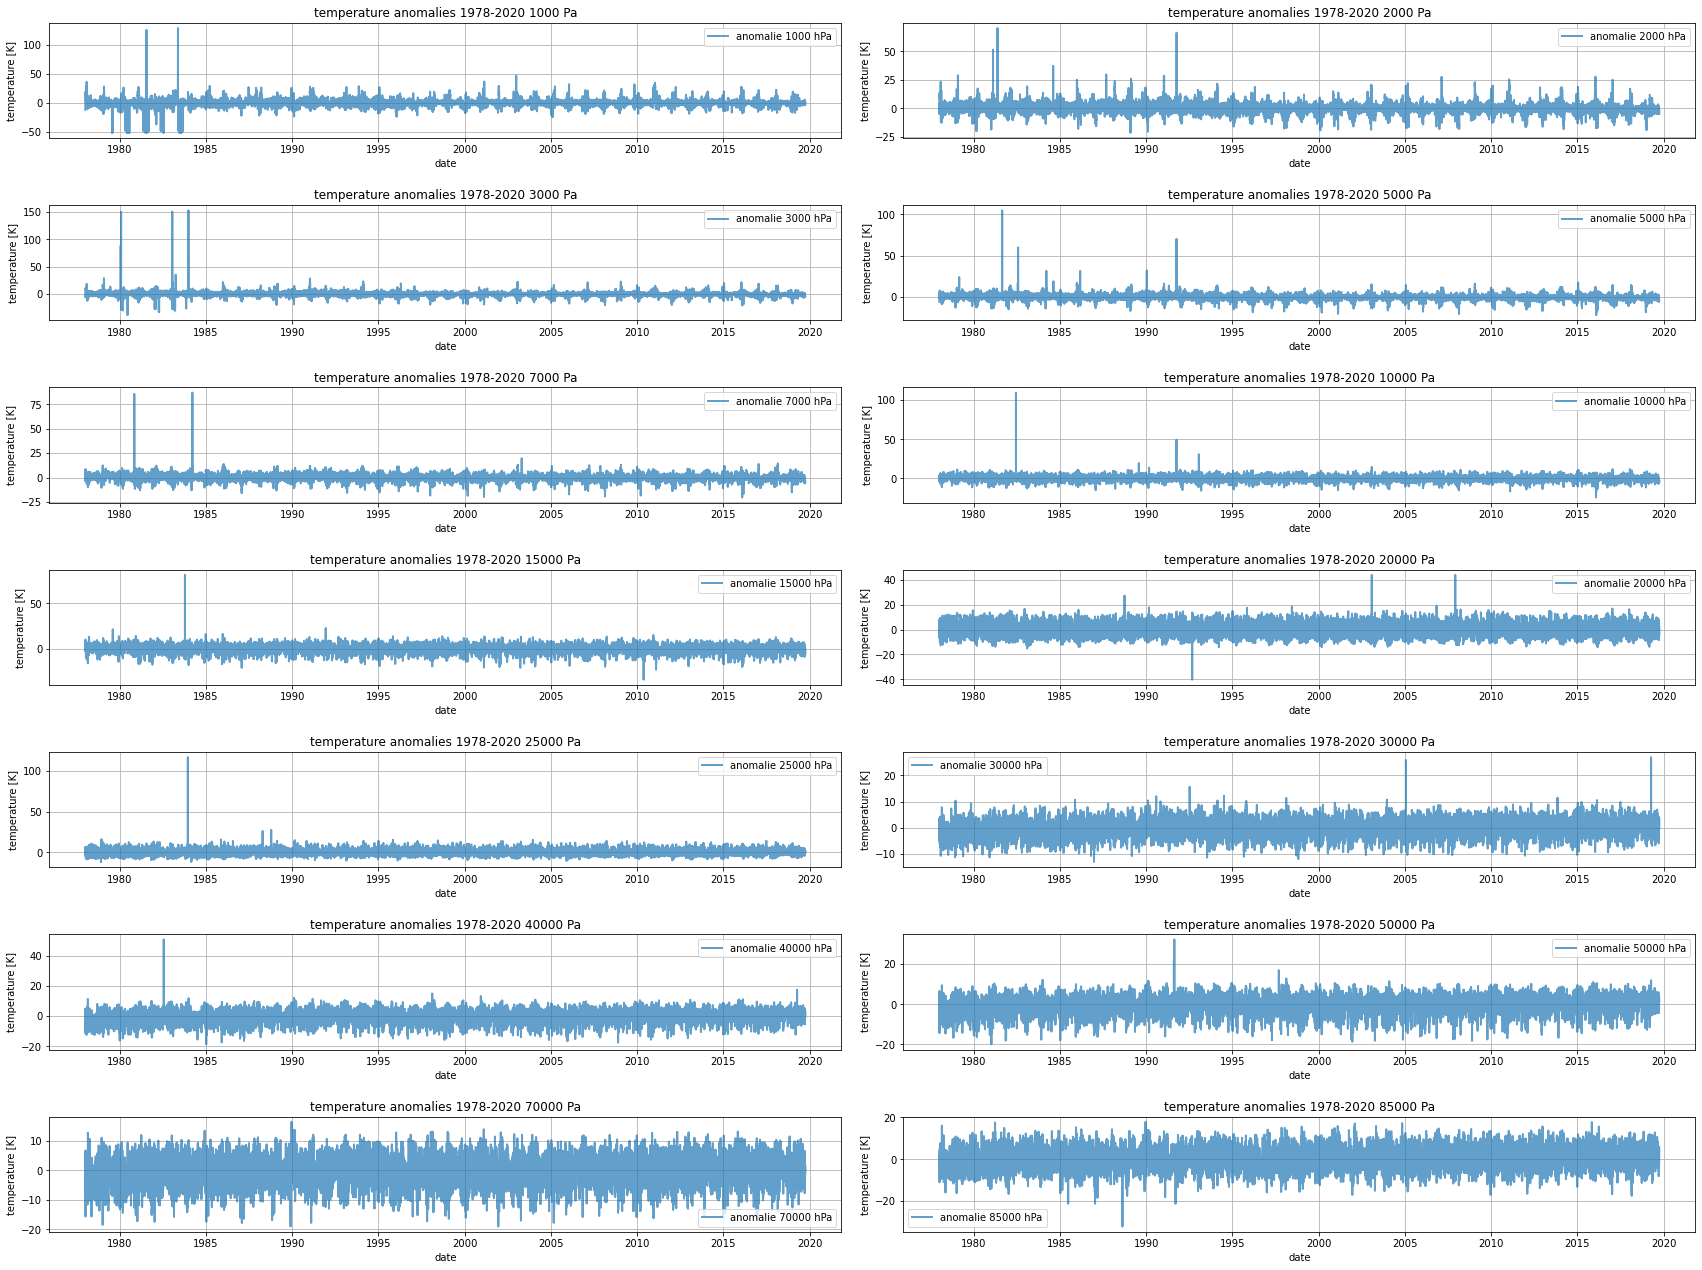

In [27]:
plt.rcParams['figure.figsize'] = [24, 18]
fig, axs = plt.subplots(7, 2)
axs = axs.ravel()
plevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000]
for i in range(len(plevs)):
    axs[i].grid()
    axs[i].set(xlabel='date', ylabel='temperature [K]', title='temperature anomalies 1978-2020 '+ str(plevs[i])+' Pa')
    anoms = anomalies[str(plevs[i])][0]
    axs[i].plot(data[data.z_coordinate == plevs[i]].date_time, anoms , label='anomalie '+str(plevs[i])+' hPa', linewidth=2, alpha=0.7)
    axs[i].legend()
fig.tight_layout(pad=2.0)
plt.show()

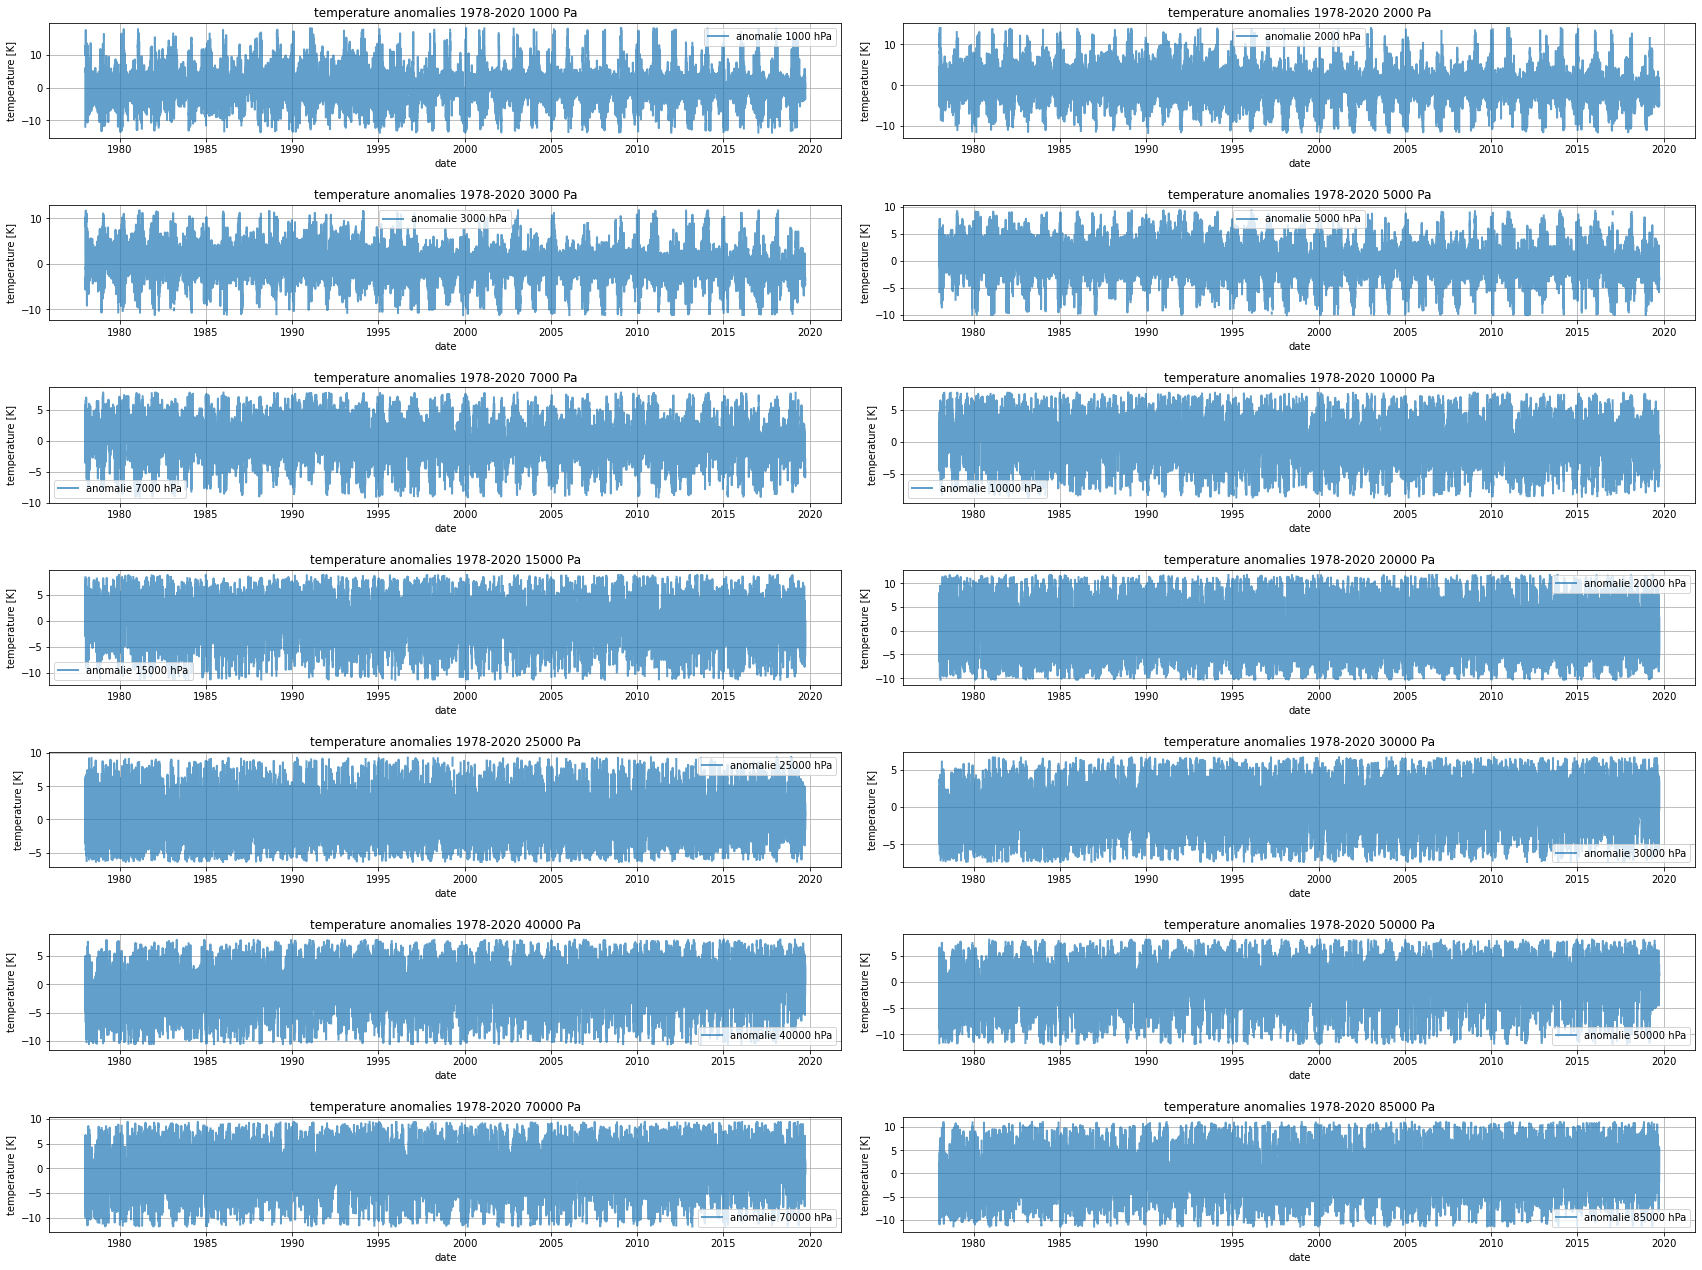

In [28]:
plt.rcParams['figure.figsize'] = [24, 18]
fig, axs = plt.subplots(7, 2)
axs = axs.ravel()
plevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000]
for i in range(len(plevs)):
    axs[i].grid()
    axs[i].set(xlabel='date', ylabel='temperature [K]', title='temperature anomalies 1978-2020 '+ str(plevs[i])+' Pa')
    anoms = anomalies[str(plevs[i])][0]
    anoms[anoms > np.nanquantile(anoms, 0.99)] = np.nan
    anoms[anoms < np.nanquantile(anoms, 0.01)] = np.nan
    axs[i].plot(data[data.z_coordinate == plevs[i]].date_time, anoms , label='anomalie '+str(plevs[i])+' hPa', linewidth=2, alpha=0.7)
    axs[i].legend()
fig.tight_layout(pad=2.0)
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [24, 18]
fig, axs = plt.subplots(7, 2)
axs = axs.ravel()
plevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000]
for i in range(len(plevs)):
    axs[i].grid()
    axs[i].set(xlabel='date', ylabel='temperature [K]', title='temperature anomalies 1978-2020 '+ str(plevs[i])+' Pa')
    anoms = anomalies[str(plevs[i])][0]
    anoms[anoms > np.nanquantile(anoms, 0.99)] = np.nan
    anoms[anoms < np.nanquantile(anoms, 0.01)] = np.nan
    axs[i].plot(data[data.z_coordinate == plevs[i]].date_time, anoms , label='anomalie '+str(plevs[i])+' hPa', linewidth=2, alpha=0.7)
    axs[i].legend()
fig.tight_layout(pad=2.0)
plt.show()

## 3) simulation of a request coming from the CDS form by setting as filters a geographic area (defining a bounding box with the latitude and longitude ranges) and a time range on a monthly basis

In [30]:
request({'variable': 'air_temperature',
         'area': [50,15,45,20], #[lat_max, lon_min, lat_min, lon_max] <-> [N, W, S, E] - same sequence like in the CDS form
         'date': '20000101-20000131',
         'format': 'fast_csv',
         'cached': 3,
        }, 
        'insitu-comprehensive-upper-air-observation-network',
        data_dir = './comparison_dir/2',
        rm_files = False)

2021-11-19 15:09:53,220 INFO Welcome to the CDS
2021-11-19 15:09:53,221 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-11-19 15:09:58,621 INFO Request is completed
2021-11-19 15:09:58,622 INFO Downloading http://download-0001-sisdev.copernicus-climate.eu/cache-compute-0001/cache/data1/adaptor.comprehensive_upper_air.retrieve-1637154840.0856469-5549-1-0f91d251-e279-421a-b8a2-2fa3a86a38d0.zip to download.zip (103.5K)
2021-11-19 15:09:59,616 INFO Download rate 104.3K/s                             


request:  5.516849040985107  s
download:  0.9942953586578369  s
over all :  6.511144399642944  s 
-
unzip:  0.06344485282897949  s 
-
zip size:  0.106035  MB
file size:  0.63621  MB


In [31]:
glob.glob('./comparison_dir/2/*')

['./comparison_dir/2/dest_0-20000-0-11723_air_temperature.csv.gz',
 './comparison_dir/2/dest_0-20000-0-11240_air_temperature.csv.gz',
 './comparison_dir/2/dest_0-20000-0-11747_air_temperature.csv.gz',
 './comparison_dir/2/dest_0-20000-0-14240_air_temperature.csv.gz',
 './comparison_dir/2/dest_0-20000-0-12843_air_temperature.csv.gz',
 './comparison_dir/2/dest_0-20001-0-11035_air_temperature.csv.gz']